In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator
from matplotlib.gridspec import GridSpec
import glob

from statsmodels.stats.proportion import proportion_confint

from dust_extinction.dust import extinction_cal

In [2]:
%matplotlib notebook

In [3]:
yao_sample_dir = '../../../../SN19yvq/data/P48/SN2019yvq/data/Yao2019/data_fig11/'
ztf18_sne_files = glob.glob(yao_sample_dir + 'ZTF18*.dat')
salt_df = pd.read_csv(yao_sample_dir + '../Nobs_cut_salt2_spec_subtype_pec.csv')

In [4]:
ebv_snoopy = pd.read_csv('../../../../SN19yvq/data/comp_sne/ztf_ia_2018/ebv_sbv.txt', 
                       delim_whitespace=True)

In [5]:
for lcf in ztf18_sne_files:
    ztf_name = lcf.split('/')[-1].split('.')[0]
    this_sn = np.where(salt_df.name == ztf_name)

    ebv_host = ebv_snoopy.iloc[np.where(ebv_snoopy.sn == ztf_name)].ebv.values[0]
    a_g = extinction_cal.calALambda(4722.74, 3.1, ebv_host)
    a_r = extinction_cal.calALambda(6339.61, 3.1, ebv_host)

<IPython.core.display.Javascript object>


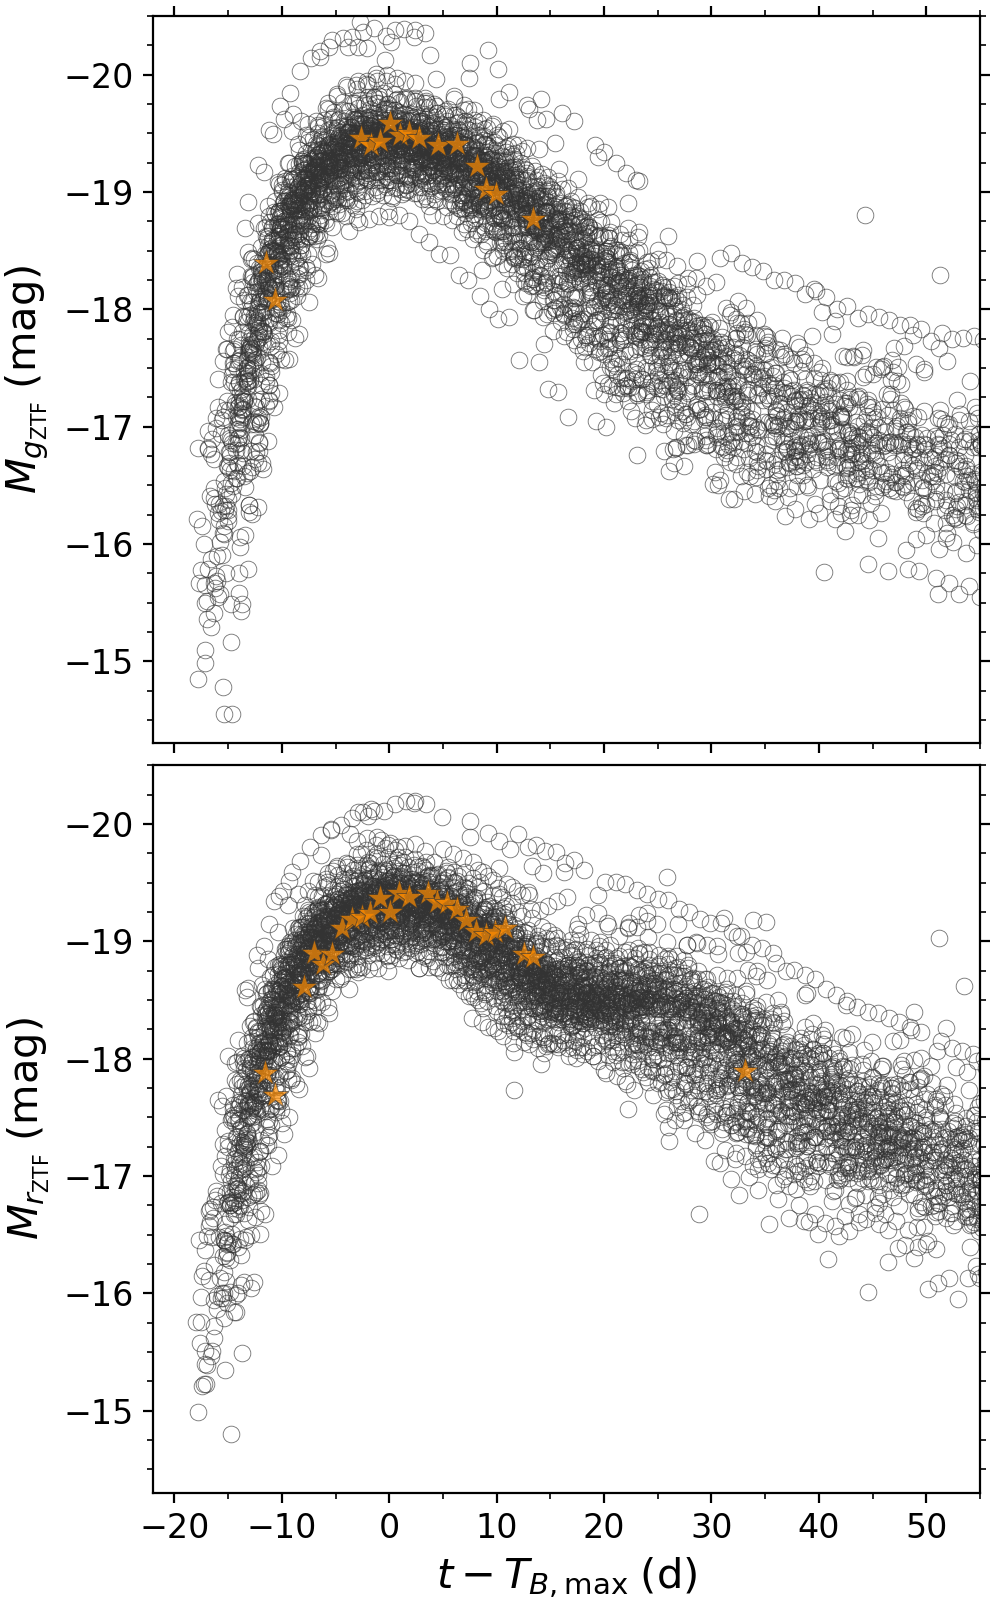

ZTF18abptsco
[-18.3951445  -18.08350712 -19.46438478 -19.4030254  -19.43569894]
[0.15355715 0.2353818  0.0491706  0.0628669  0.05641209]
[-17.8818372  -17.68628366 -18.61211195 -18.90446272 -18.80823334]
[0.1853561  0.2269783  0.13370214 0.0946845  0.12772989]
ZTF18abklljv
[-18.42698353 -18.32849831 -18.38866339 -19.24737869 -19.29973375]
[0.18031861 0.1853324  0.19248274 0.08597909 0.02655751]
[-18.02447161 -17.97217521 -18.63078986 -18.50949347 -18.95172388]
[0.26990303 0.20498954 0.22590749 0.29393578 0.06771881]


In [6]:
fig, (axg, axr) = plt.subplots(2, 1, figsize=(5,8))

n_sn = 0

n_faint = 0 
n_fainter = 0 
n_very_faint = 0
for lcf in ztf18_sne_files:
    ztf_name = lcf.split('/')[-1].split('.')[0]
    this_sn = np.where(salt_df.name == ztf_name)
    if ( #(salt_df['z_source'].iloc[this_sn].values[0] == 'Msl') or 
        (salt_df['Ia subtype'].iloc[this_sn].values[0] in ['SC', 'SC*', 'Ia-CSM', '86G-like'])
       ):
        continue
    
    ebv_host = ebv_snoopy.iloc[np.where(ebv_snoopy.sn == ztf_name)].ebv.values[0]
    if ebv_host > 0:
        a_g = extinction_cal.calALambda(4722.74, 3.1, ebv_host)
        a_r = extinction_cal.calALambda(6339.61, 3.1, ebv_host)
    else:
        a_g = 0
        a_r = 0
    
    lc_df = pd.read_csv(lcf, delim_whitespace=True)
    
    g_obs = np.where((lc_df.fid == 1) & (lc_df.mag_unc < 0.3))
    r_obs = np.where((lc_df.fid == 2) & (lc_df.mag_unc < 0.3))
    t_offset = ((salt_df.t0_B_salt2.values - 
                 salt_df.t0_g_adopted.values)/
                (1 + salt_df.z_adopt.values))[this_sn]

    
    # K corrections
    gKcorr = pd.read_csv('../../../../SN19yvq/data/comp_sne/ztf_ia_2018/{}_gKcorr.ascii'.format(ztf_name), 
                     delim_whitespace=True, names=['MJD', 'kmag'])
    rKcorr = pd.read_csv('../../../../SN19yvq/data/comp_sne/ztf_ia_2018/{}_rKcorr.ascii'.format(ztf_name), 
                         delim_whitespace=True, names=['MJD', 'kmag'])
    mjd_obs = (lc_df.t.values)*(1+salt_df.z_adopt.iloc[this_sn].values) + salt_df.t0_g_adopted.iloc[this_sn].values - 2400000.5
    
    sn_gkcorr = np.zeros_like(lc_df.iloc[g_obs].t.values)
    sn_rkcorr = np.zeros_like(lc_df.iloc[r_obs].t.values)

    for obs_num, mjd in enumerate(mjd_obs[g_obs]):
        if np.min(np.abs(mjd - gKcorr.MJD.values)) < 0.4:
            sn_gkcorr[obs_num] = gKcorr.kmag.values[np.argmin(np.abs(mjd - gKcorr.MJD.values))]

    for obs_num, mjd in enumerate(mjd_obs[r_obs]):
        if np.min(np.abs(mjd - rKcorr.MJD.values)) < 0.4:
            sn_rkcorr[obs_num] = rKcorr.kmag.values[np.argmin(np.abs(mjd - rKcorr.MJD.values))]
    
    has_g_Kcorr = np.where(sn_gkcorr != 0)
    axg.plot(lc_df.iloc[g_obs].t.values[has_g_Kcorr] - t_offset, 
             lc_df.iloc[g_obs].mag.values[has_g_Kcorr] - a_g - sn_gkcorr[has_g_Kcorr],
             'o', color='None', mec='0.2', mew=0.3,  alpha=0.7)
    has_r_Kcorr = np.where(sn_rkcorr != 0)
    axr.plot(lc_df.iloc[r_obs].t.values[has_r_Kcorr] - t_offset, 
         lc_df.iloc[r_obs].mag.values[has_r_Kcorr] - a_r - sn_rkcorr[has_r_Kcorr],
         'o', color='None', mec='0.2', mew=0.3,  alpha=0.7)
    if ztf_name == 'ZTF18abptsco': #'ZTF18abeegsl':
        axg.plot(lc_df.iloc[g_obs].t.values[has_g_Kcorr], 
                 lc_df.iloc[g_obs].mag.values[has_g_Kcorr] - a_g - sn_gkcorr[has_g_Kcorr],
                 '*', color='DarkOrange', mec='0.2', mew=0.3,  alpha=0.7, ms=10, zorder=100)
        axr.plot(lc_df.iloc[r_obs].t.values[has_r_Kcorr], 
                 lc_df.iloc[r_obs].mag.values[has_r_Kcorr] - a_r - sn_rkcorr[has_r_Kcorr],
                 '*', color='DarkOrange', mec='0.2', mew=0.3,  alpha=0.7, ms=10, zorder=100)        

    t_rf = np.append(lc_df.iloc[g_obs].t.values[has_g_Kcorr], lc_df.iloc[r_obs].t.values[has_r_Kcorr])
    mag = np.append(lc_df.iloc[g_obs].mag.values[has_g_Kcorr] - a_g - sn_gkcorr[has_g_Kcorr],
                    lc_df.iloc[r_obs].mag.values[has_r_Kcorr] - a_r - sn_rkcorr[has_r_Kcorr])
    mag_unc = np.append(lc_df.iloc[g_obs].mag_unc.values[has_g_Kcorr],
                        lc_df.iloc[r_obs].mag_unc.values[has_r_Kcorr])
    fid = np.append(lc_df.iloc[g_obs].fid.values[has_g_Kcorr],
                    lc_df.iloc[r_obs].fid.values[has_r_Kcorr])
    kcorr_df = pd.DataFrame(t_rf, columns=['t_gmax'])
    kcorr_df['mag'] = mag
    kcorr_df['mag_unc'] = mag_unc
    kcorr_df['fid'] = fid
    kcorr_df.to_csv('{}_kcorr.csv'.format(ztf_name))
    
    g_abs = lc_df.iloc[g_obs].mag.values[has_g_Kcorr] - a_g - sn_gkcorr[has_g_Kcorr]
    g_unc = lc_df.iloc[g_obs].mag_unc.values[has_g_Kcorr]
    r_abs = lc_df.iloc[r_obs].mag.values[has_r_Kcorr] - a_r - sn_rkcorr[has_r_Kcorr]
    r_unc = lc_df.iloc[r_obs].mag_unc.values[has_r_Kcorr]
    if (max(g_abs[0:5]) > -16.5) & (max(r_abs[0:5]) > -16.5):
        n_faint += 1
    if (max(g_abs[0:5]) > -16.) & (max(r_abs[0:5]) > -16.):
        n_fainter += 1
    if (max(g_abs[0:5]) > -15.5) & (max(r_abs[0:5]) > -15.5):
        n_very_faint += 1
    if (g_abs[0]-g_abs[1] < 0) & (r_abs[0]-r_abs[1] < 0):
        print(ztf_name)
        print(g_abs[0:5])
        print(g_unc[0:5])
        print(r_abs[0:5])
        print(r_unc[0:5])

    if (g_abs[0]-g_abs[2] < 0) & (r_abs[0]-r_abs[2] < 0):
        print(ztf_name, ' 3rd fainter than 1st')
        print(g_abs[0:5])
        print(g_unc[0:5])
        print(r_abs[0:5])
        print(r_unc[0:5])

    if (g_abs[1]-g_abs[2] < 0) & (r_abs[1]-r_abs[2] < 0):
        print(ztf_name, ' 3rd fainter than 2nd')
        print(g_abs[0:5])
        print(g_unc[0:5])
        print(r_abs[0:5])
        print(r_unc[0:5])

        
for ax in [axg, axr]:
    ax.set_xlim(-22, 55)
    ax.set_ylim(-14.3, -20.5)
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.25))
    
axg.tick_params(which='both', top=True, right=True, labelsize=12)
axr.tick_params(which='both', right=True, labelsize=12)
axg.set_xticklabels([])
axg.set_ylabel(r'$M_{g_\mathrm{ZTF}} \;(\mathrm{mag})$', fontsize=15)
axr.set_ylabel(r'$M_{r_\mathrm{ZTF}} \;(\mathrm{mag})$', fontsize=15)
axr.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize=15)

fig.subplots_adjust(top=0.99, right=0.98, left=0.153, bottom=0.067, hspace=0.03)


In [7]:
print(n_faint)
print(n_fainter)
print(n_very_faint)

33
15
8


In [8]:
print(proportion_confint(0,n_faint, method='beta'))
print(proportion_confint(0,n_fainter, method='beta'))
print(proportion_confint(0,n_very_faint, method='beta'))

(0, 0.10576281007457931)
(0, 0.2180193609105339)
(0, 0.3694166475528191)


In [9]:
print(proportion_confint(0,n_faint, method='jeffreys'))
print(proportion_confint(0,n_fainter, method='jeffreys'))
print(proportion_confint(0,n_very_faint, method='jeffreys'))

(1.4767430104586674e-05, 0.07275870531262567)
(3.2194144323726923e-05, 0.15181666211439768)
(5.949030289440227e-05, 0.26221724871718577)


In [10]:
print(proportion_confint(0,127, method='beta'))

(0, 0.02862850613438765)
